# Chapter 3

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

Downloaded thinkstats2.py
Downloaded thinkplot.py
Downloaded nsfg.py
Downloaded first.py
Downloaded 2002FemPreg.dct
Downloaded 2002FemPreg.dat.gz


In [2]:
import numpy as np

Again, I'll load the NSFG pregnancy file and select live births:

In [3]:
import nsfg
import first
import thinkstats2
import thinkplot

In [4]:
preg = nsfg.ReadFemPreg()
live = preg[preg.outcome == 1]

Here's the histogram of birth weights:

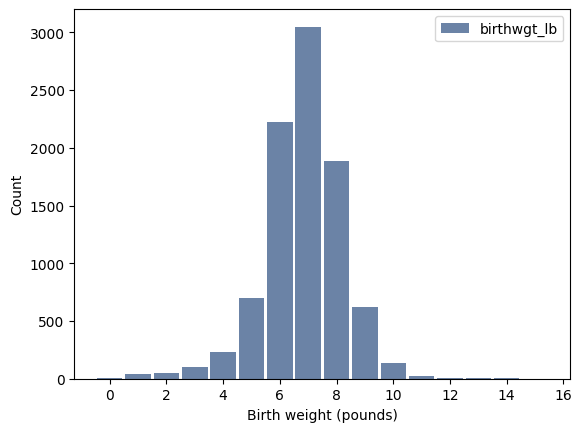

In [5]:
hist = thinkstats2.Hist(live.birthwgt_lb, label="birthwgt_lb")
thinkplot.Hist(hist)
thinkplot.Config(xlabel="Birth weight (pounds)", ylabel="Count")

To normalize the disrtibution, we could divide through by the total count:

In [6]:
n = hist.Total()
pmf = hist.Copy()
for x, freq in hist.Items():
    pmf[x] = freq / n

The result is a Probability Mass Function (PMF).

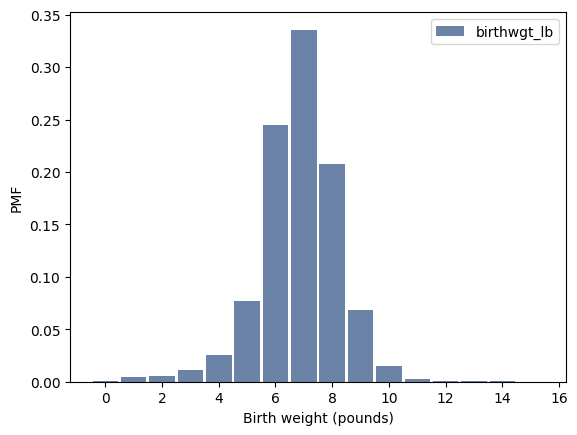

In [7]:
thinkplot.Hist(pmf)
thinkplot.Config(xlabel="Birth weight (pounds)", ylabel="PMF")

More directly, we can create a Pmf object.

In [8]:
pmf = thinkstats2.Pmf([1, 2, 2, 3, 5])
pmf

Pmf({1: 0.2, 2: 0.4, 3: 0.2, 5: 0.2})

`Pmf` provides `Prob`, which looks up a value and returns its probability:

In [9]:
pmf.Prob(2)

0.4

The bracket operator does the same thing.

In [10]:
pmf[2]

0.4

The `Incr` method adds to the probability associated with a given values.

In [11]:
pmf.Incr(2, 0.2)
pmf[2]

0.6000000000000001

The `Mult` method multiplies the probability associated with a value.

In [12]:
pmf.Mult(2, 0.5)
pmf[2]

0.30000000000000004

`Total` returns the total probability (which is no longer 1, because we changed one of the probabilities).

In [13]:
pmf.Total()

0.8999999999999999

`Normalize` divides through by the total probability, making it 1 again.

In [14]:
pmf.Normalize()
pmf.Total()

1.0

Here's the PMF of pregnancy length for live births.

In [15]:
pmf = thinkstats2.Pmf(live.prglngth, label="prglngth")

Here's what it looks like plotted with `Hist`, which makes a bar graph.

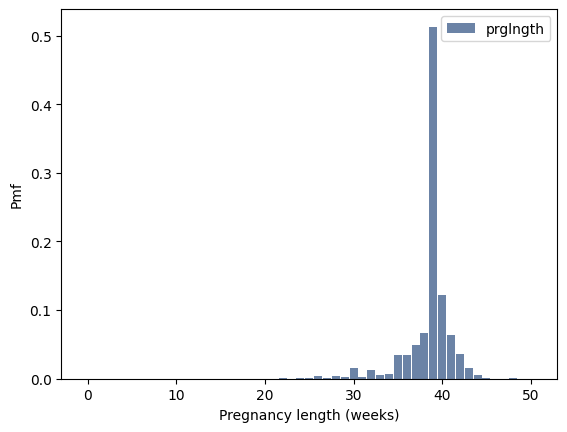

In [16]:
thinkplot.Hist(pmf)
thinkplot.Config(xlabel="Pregnancy length (weeks)", ylabel="Pmf")

Here's what it looks like plotted with `Pmf`, which makes a step function.

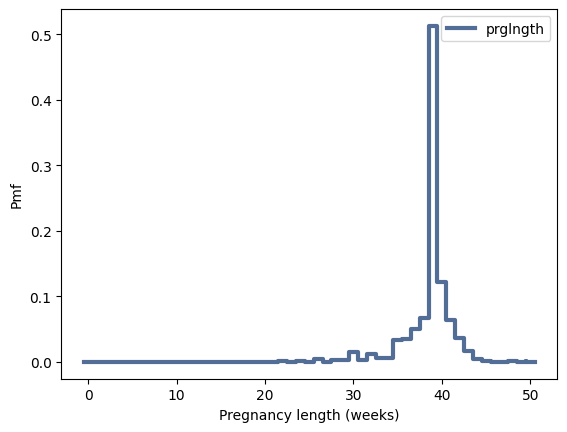

In [17]:
thinkplot.Pmf(pmf)
thinkplot.Config(xlabel="Pregnancy length (weeks)", ylabel="Pmf")

We can use `MakeFrames` to return DataFrames for all live births, first babies, and others.

In [18]:
live, firsts, others = first.MakeFrames()

Here are the distributions of pregnancy length.

In [19]:
first_pmf = thinkstats2.Pmf(firsts.prglngth, label="firsts")
other_pmf = thinkstats2.Pmf(others.prglngth, label="others")

And here's the code that replicates one of the figures in the chapter.

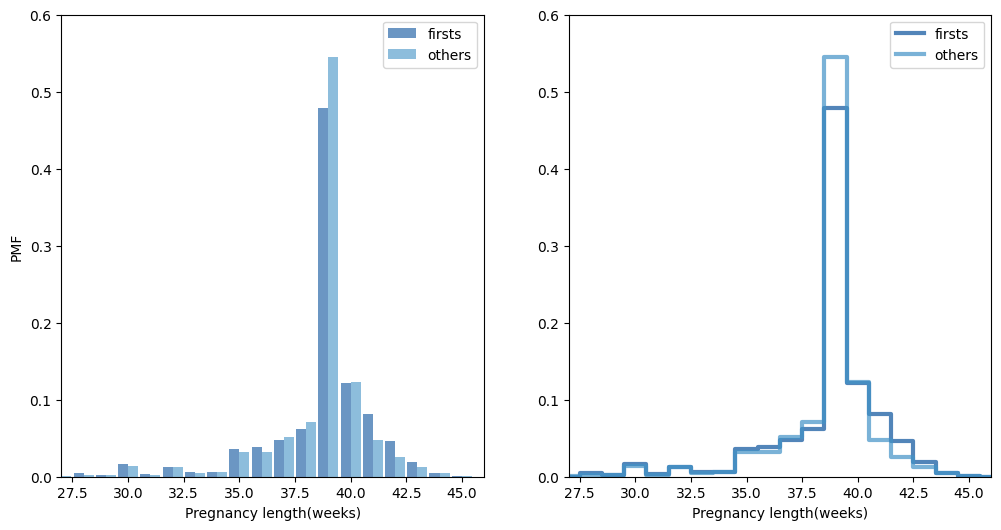

In [20]:
width = 0.45
axis = [27, 46, 0, 0.6]
thinkplot.PrePlot(2, cols=2)
thinkplot.Hist(first_pmf, align="right", width=width)
thinkplot.Hist(other_pmf, align="left", width=width)
thinkplot.Config(xlabel="Pregnancy length(weeks)", ylabel="PMF", axis=axis)

thinkplot.PrePlot(2)
thinkplot.SubPlot(2)
thinkplot.Pmfs([first_pmf, other_pmf])
thinkplot.Config(xlabel="Pregnancy length(weeks)", axis=axis)

Here's the code that generates a plot of the difference in probability (in percentage points) between first babies and others, for each week of pregnancy (showing only pregnancies considered "full term"). 

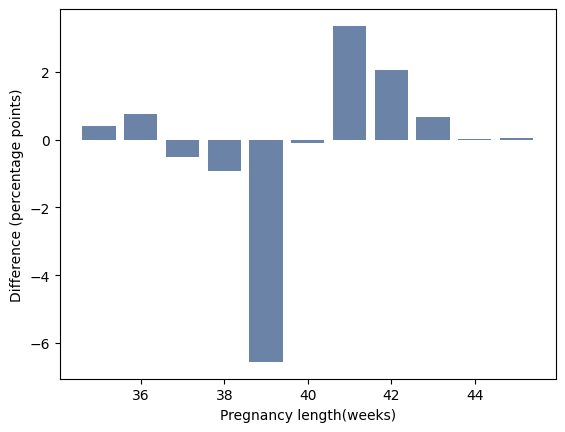

In [21]:
weeks = range(35, 46)
diffs = []
for week in weeks:
    p1 = first_pmf.Prob(week)
    p2 = other_pmf.Prob(week)
    diff = 100 * (p1 - p2)
    diffs.append(diff)

thinkplot.Bar(weeks, diffs)
thinkplot.Config(xlabel='Pregnancy length(weeks)', ylabel='Difference (percentage points)')


### Biasing and unbiasing PMFs

Here's the example in the book showing operations we can perform with `Pmf` objects.

Suppose we have the following distribution of class sizes.

In [22]:
d = {7: 8, 12: 8, 17: 14, 22: 4, 27: 6, 32: 12, 37: 8, 42: 3, 47: 2}

pmf = thinkstats2.Pmf(d, label="actual")

This function computes the biased PMF we would get if we surveyed students and asked about the size of the classes they are in.

In [23]:
def BiasPmf(pmf, label):
    new_pmf = pmf.Copy(label=label)

    for x, p in pmf.Items():
        new_pmf.Mult(x, x)

    new_pmf.Normalize()
    return new_pmf

The following graph shows the difference between the actual and observed distributions.

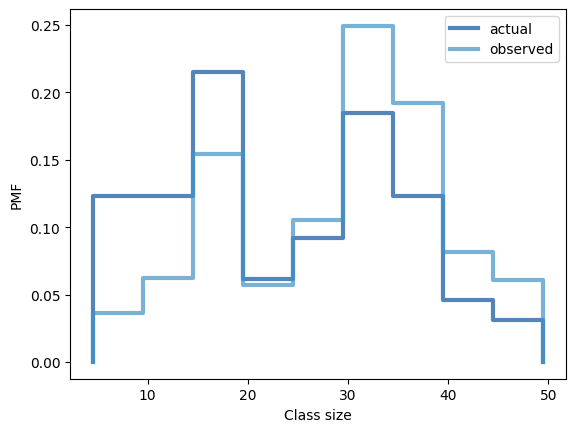

In [24]:
biased_pmf = BiasPmf(pmf, label="observed")
thinkplot.PrePlot(2)
thinkplot.Pmfs([pmf, biased_pmf])
thinkplot.Config(xlabel="Class size", ylabel="PMF")

The observed mean is substantially higher than the actual.

In [25]:
print("Actual mean", pmf.Mean())
print("Observed mean", biased_pmf.Mean())

Actual mean 23.692307692307693
Observed mean 29.123376623376625


If we were only able to collect the biased sample, we could "unbias" it by applying the inverse operation.

In [26]:
def UnbiasPmf(pmf, label=None):
    new_pmf = pmf.Copy(label=label)

    for x, p in pmf.Items():
        new_pmf[x] *= 1 / x

    new_pmf.Normalize()
    return new_pmf

We can unbias the biased PMF:

In [27]:
unbiased = UnbiasPmf(biased_pmf, label="unbiased")
print("Unbiased mean", unbiased.Mean())

Unbiased mean 23.69230769230769


And plot the two distributions to confirm they are the same.

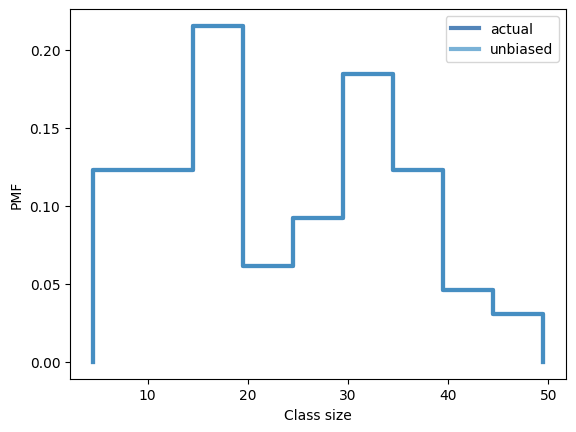

In [28]:
thinkplot.PrePlot(2)
thinkplot.Pmfs([pmf, unbiased])
thinkplot.Config(xlabel="Class size", ylabel="PMF")

### Pandas indexing

Here's an example of a small DataFrame.

In [29]:
import numpy as np
import pandas

array = np.random.randn(4, 2)
df = pandas.DataFrame(array)
df

,0,1
0,1.103339,1.699210
1,1.916441,-1.405964
2,0.653422,0.235700
3,-0.520686,-0.493651


We can specify column names when we create the DataFrame:

In [30]:
columns = ["A", "B"]
df = pandas.DataFrame(array, columns=columns)
df

,A,B
0,1.103339,1.699210
1,1.916441,-1.405964
2,0.653422,0.235700
3,-0.520686,-0.493651


We can also specify an index that contains labels for the rows.

In [31]:
index = ["a", "b", "c", "d"]
df = pandas.DataFrame(array, columns=columns, index=index)
df

,A,B
a,1.103339,1.699210
b,1.916441,-1.405964
c,0.653422,0.235700
d,-0.520686,-0.493651


Normal indexing selects columns.

In [32]:
df["A"]

a    1.103339
b    1.916441
c    0.653422
d   -0.520686
Name: A, dtype: float64

We can use the `loc` attribute to select rows.

In [33]:
df.loc["a"]

A    1.103339
B    1.699210
Name: a, dtype: float64

If you don't want to use the row labels and prefer to access the rows using integer indices, you can use the `iloc` attribute:

In [34]:
df.iloc[0]

A    1.103339
B    1.699210
Name: a, dtype: float64

`loc` can also take a list of labels.

In [35]:
indices = ["a", "c"]
df.loc[indices]

,A,B
a,1.103339,1.69921
c,0.653422,0.23570


If you provide a slice of labels, `DataFrame` uses it to select rows.

In [36]:
df["a":"c"]

,A,B
a,1.103339,1.699210
b,1.916441,-1.405964
c,0.653422,0.235700


If you provide a slice of integers, `DataFrame` selects rows by integer index.

In [37]:
df[0:2]

,A,B
a,1.103339,1.699210
b,1.916441,-1.405964


But notice that one method includes the last elements of the slice and one does not.

In general, I recommend giving labels to the rows and names to the columns, and using them consistently.

## Exercises

**Exercise:** In Chapter 3 we computed the mean of a sample by adding up
the elements and dividing by n.  If you are given a PMF, you can
still compute the mean, but the process is slightly different:
%
$$ \bar x = \sum_i p_i~x_i $$
%
where the $x_i$ are the unique values in the PMF and $p_i=PMF(x_i)$.
Similarly, you can compute variance like this:
%
$$ S^2 = \sum_i p_i~(x_i - \bar x)^2 $$
% 
Write functions called `PmfMean` and `PmfVar` that take a
Pmf object and compute the mean and variance.  To test these methods,
check that they are consistent with the methods `Mean` and `Var`
provided by `Pmf`.

In [38]:
def PmfMean(pmf):
    """Computes the mean of a PMF.
    Returns:
        float mean
    """
    return sum(p * x for x, p in pmf.Items())

In [39]:
def PmfVar(pmf, mu=None):
    """Computes the variance of a PMF.
    mu: the point around which the variance is computed;
            if omitted, computes the mean
    returns: float variance
    """
    if mu is None:
        mu = PmfMean(pmf)

    return sum(p * (x - mu) ** 2 for x, p in pmf.Items())

**Exercise:** Something like the class size paradox appears if you survey children and ask how many children are in their family. Families with many children are more likely to appear in your sample, and families with no children have no chance to be in the sample.

Use the NSFG respondent variable `numkdhh` to construct the actual distribution for the number of children under 18 in the respondents' households.

Now compute the biased distribution we would see if we surveyed the children and asked them how many children under 18 (including themselves) are in their household.

Plot the actual and biased distributions, and compute their means.

In [40]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")

Downloaded 2002FemResp.dct
Downloaded 2002FemResp.dat.gz


In [41]:
resp = nsfg.ReadFemResp()

In [42]:
pmf = thinkstats2.Pmf(resp.numkdhh, label='actual')

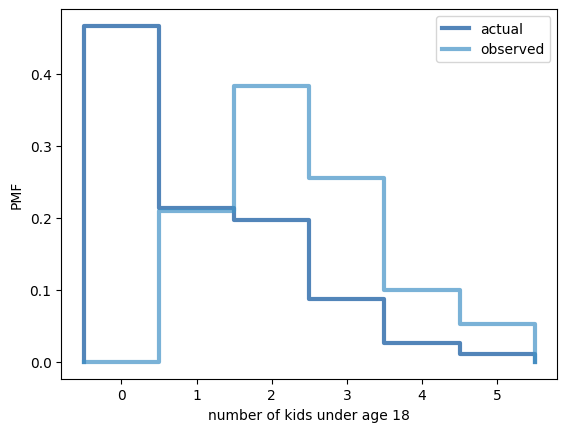

In [43]:
biased_pmf = BiasPmf(pmf, label="observed")
thinkplot.PrePlot(2)
thinkplot.Pmfs([pmf, biased_pmf])
thinkplot.Config(xlabel="number of kids under age 18", ylabel="PMF")

In [44]:
pmf_mean = PmfMean(pmf)
pmf_mean

1.024205155043831

In [45]:
biased_pmf_mean = PmfMean(biased_pmf)
biased_pmf_mean

2.403679100664282

**Exercise:** I started this book with the question, "Are first babies more likely to be late?" To address it, I computed the difference in means between groups of babies, but I ignored the possibility that there might be a difference between first babies and others for the same woman.

To address this version of the question, select respondents who have at least two live births and compute pairwise differences. Does this formulation of the question yield a different result?

Hint: use `nsfg.MakePregMap`:

In [46]:
live, firsts, others = first.MakeFrames()

In [47]:
preg_map = nsfg.MakePregMap(live)

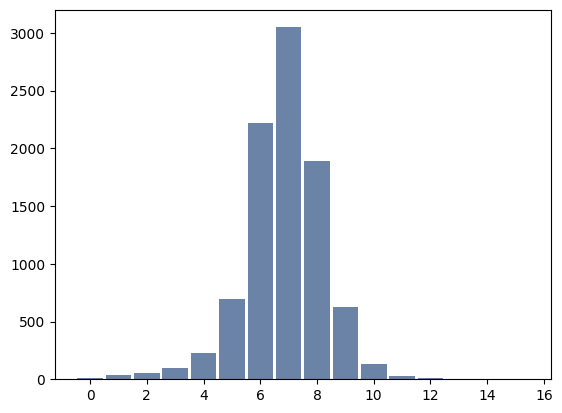

In [48]:
from collections import defaultdict

freqs = defaultdict(int)
for caseid, preg_ids in preg_map.items():
  if len(preg_ids) >= 2:
    preg_lngths = preg.loc[preg_ids[0:2], 'prglngth']
    diff = np.diff(preg_lngths)[0]
    freqs[diff] += 1

hist = thinkstats2.Hist(hist)
thinkplot.Hist(hist)

**Exercise:** In most foot races, everyone starts at the same time. If you are a fast runner, you usually pass a lot of people at the beginning of the race, but after a few miles everyone around you is going at the same speed.
When I ran a long-distance (209 miles) relay race for the first time, I noticed an odd phenomenon: when I overtook another runner, I was usually much faster, and when another runner overtook me, he was usually much faster.

At first I thought that the distribution of speeds might be bimodal; that is, there were many slow runners and many fast runners, but few at my speed.

Then I realized that I was the victim of a bias similar to the effect of class size. The race was unusual in two ways: it used a staggered start, so teams started at different times; also, many teams included runners at different levels of ability.

As a result, runners were spread out along the course with little relationship between speed and location. When I joined the race, the runners near me were (pretty much) a random sample of the runners in the race.

So where does the bias come from? During my time on the course, the chance of overtaking a runner, or being overtaken, is proportional to the difference in our speeds. I am more likely to catch a slow runner, and more likely to be caught by a fast runner. But runners at the same speed are unlikely to see each other.

Write a function called `ObservedPmf` that takes a `Pmf` representing the actual distribution of runners’ speeds, and the speed of a running observer, and returns a new `Pmf` representing the distribution of runners’ speeds as seen by the observer.

To test your function, you can use `relay.py`, which reads the results from the James Joyce Ramble 10K in Dedham MA and converts the pace of each runner to mph.

Compute the distribution of speeds you would observe if you ran a relay race at 7 mph with this group of runners.

In [49]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/relay.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/Apr25_27thAn_set1.shtml")

Downloaded relay.py
Downloaded Apr25_27thAn_set1.shtml


In [50]:
import relay

results = relay.ReadResults()
speeds = relay.GetSpeeds(results)
speeds = relay.BinData(speeds, 3, 12, 100)
speeds

array([12.09, 11.73, 11.73, ...,  3.27,  3.27,  3.09])

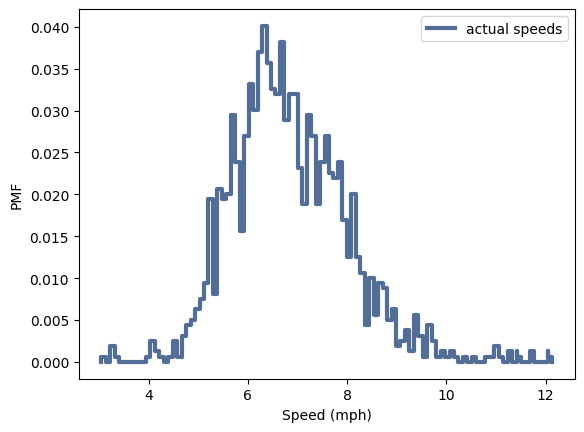

In [51]:
pmf = thinkstats2.Pmf(speeds, "actual speeds")
thinkplot.Pmf(pmf)
thinkplot.Config(xlabel="Speed (mph)", ylabel="PMF")

In [52]:
def BiasedPmf(pmf, speed, label=None):
  """Returns Pmf of speeds observed at a given speed.
  Args:
    pmf: distribution of actual speeds
    speed: speedof the runner
    label: label for the Pmf
    
  Returns:
    Pmf object
  """
  biased_pmf = pmf.Copy(label=label)
  for val in biased_pmf.Values():
    diff = abs(val - speed)
    biased_pmf[val] *= diff
  biased_pmf.Normalize()
  return biased_pmf

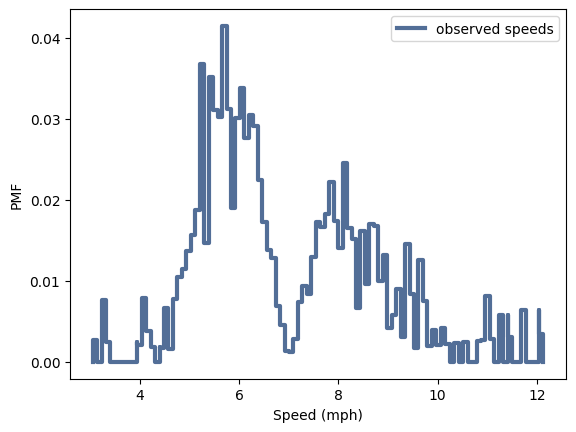

In [53]:
biased_pmf = BiasedPmf(pmf, 7, label='observed speeds')
thinkplot.Pmf(biased_pmf)
thinkplot.Config(xlabel='Speed (mph)', ylabel='PMF')